In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from numpy import array
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential,  Model, load_model
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM,  Conv1D, MaxPooling1D, GlobalMaxPooling1D, Input, Bidirectional, GlobalMaxPool1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split,KFold
from keras.layers.merge import Concatenate
from tensorflow.keras.callbacks import TensorBoard
from keras.optimizers import Adam
from datetime import datetime
import pandas as pd
import numpy as np 
import re
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data.csv")

In [4]:
filter = data["doc"] != ""
data = data[filter]
data = data.dropna()

In [5]:
data.head()

,file_name,doc,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23
0,21,Augmentation mentoplasty using Mersilene mesh....,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,33,Multiple intracranial mucoceles associated wit...,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,52,Replacement of an aortic valve cusp after neon...,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,306,The value of indium 111 leukocyte scanning in ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,334,Febrile infants less than eight weeks old. Pre...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [6]:
data_labels = data[["C01", "C02", "C03", "C04", "C05", "C06", "C07", "C08", "C09", "C10", "C11", "C12", "C13", "C14", "C15", "C16", "C17", "C18", "C19", "C20", "C21", "C22", "C23"]]
data_labels.head()

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, '# of categories')

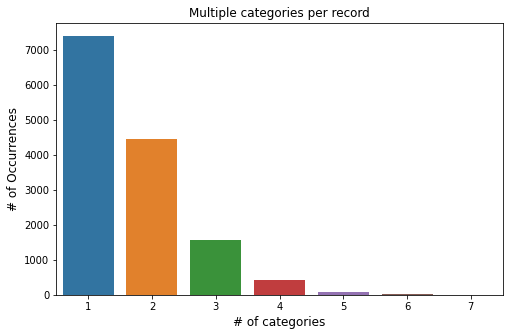

In [7]:
import seaborn as sns
rowsums = data.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per record")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

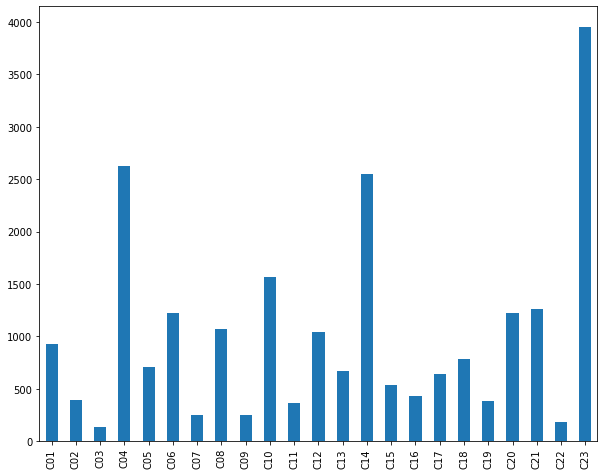

In [8]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
data_labels.sum(axis=0).plot.bar()

## **Preprocessing**

In [9]:
# convert text to lowercase
data['clean_doc'] = data['doc'].str.lower()

In [10]:
# remove punctuation marks
import string
punctuation=string.punctuation
data['clean_doc'] = data['clean_doc'].apply(lambda x: ''.join(ch for ch in x if ch not in set(punctuation)))

In [11]:
# remove numbers
data['clean_doc'] = data['clean_doc'].str.replace("[0-9]", " ")

In [12]:
# remove whitespaces
data['clean_doc'] = data['clean_doc'].apply(lambda x:' '.join(x.split()))

In [13]:
# remove stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = set(stopwords.words("english"))

def remove_stopwords(doc):
    doc = [word for word in doc.split() if word not in stop]

    return " ".join(doc)

data["clean_doc"] = data["clean_doc"].map(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
!python -m spacy download en_core_web_md 
import spacy
from spacy.lang.en import English
from spacy import displacy
nlp = spacy.load('en')

     |████████████████████████████████| 96.4MB 1.3MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-cp37-none-any.whl size=98051304 sha256=04c1b13398f3eac9355f457f0a8f95d4c096143ef5bc08fd0e701b12856f9bdc
  Stored in directory: /tmp/pip-ephem-wheel-cache-3fpau1it/wheels/df/94/ad/f5cf59224cea6b5686ac4fd1ad19c8a07bc026e13c36502d81
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [16]:
nlp = spacy.load('en', disable=['parser', 'ner'])

# function to lemmatize text
def lemmatization(texts):
    output = []
    for i in texts:
        s = [token.lemma_ for token in nlp(i)]
        output.append(' '.join(s))
    return output

In [17]:
data['clean_doc'] = lemmatization(data['clean_doc'])

In [18]:
data['doc'][10]

'Effects of epinephrine on hemodynamics and oxygen metabolism in dopamine-resistant septic shock.\n The hemodynamic effects of epinephrine were prospectively studied in 13 patients with septic shock who remained hypotensive after both fluid loading and dopamine.\n Hemodynamic measurements were performed before and one hour after the start of epinephrine infusion.\n Systolic, diastolic, and mean arterial pressure increased in all patients (p less than 0.01).\n Cardiac index and systemic vascular resistance increased by 34 and 32 percent, respectively (p less than 0.05), but heart rate and pulmonary vascular resistance remained unchanged.\n There was a concomitant increase in oxygen delivery (p less than 0.01) and oxygen consumption (p less than 0.05), the magnitude of the latter being related to baseline lactacidemia (p less than 0.01).\n In view of the generally recognized physiologic goals of septic shock management, we conclude that epinephrine could be an appropriate alternative whe

In [19]:
data['clean_doc'][10]

'effect epinephrine hemodynamics oxygen metabolism dopamineresistant septic shock hemodynamic effects epinephrine prospectively study patient septic shock remain hypotensive fluid loading dopamine hemodynamic measurement perform one hour start epinephrine infusion systolic diastolic mean arterial pressure increase patient p less cardiac index systemic vascular resistance increase percent respectively p less heart rate pulmonary vascular resistance remain unchanged concomitant increase oxygen delivery p less oxygen consumption p less magnitude latter relate baseline lactacidemia p less view generally recognize physiologic goal septic shock management conclude epinephrine could appropriate alternative fluid loading dopamine fail'

## **split data**

In [20]:
X = data["clean_doc"]
y= data_labels.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


## **tokenizer/padding**

In [21]:
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [22]:
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)
vocab_size

(11143, 200) (2786, 200)
(11143, 23) (2786, 23)


42919

## **GloVe**

In [23]:
from numpy import array
from numpy import asarray
from numpy import zeros
embeddings_dictionary = dict()

glove_file = open('/content/drive/MyDrive/glove.6B.100d.txt', encoding="utf8")
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
embeddings_dictionary['oxygen']

array([-0.69885  ,  0.71475  ,  0.44733  , -0.15373  , -0.6537   ,
       -0.25805  , -0.30386  ,  0.55434  , -0.17527  ,  0.098199 ,
        0.12904  , -0.10395  , -0.42585  ,  0.073627 ,  0.33803  ,
       -0.92496  , -0.31155  ,  0.12074  ,  0.67741  , -0.66173  ,
       -0.63822  , -0.7533   , -0.24079  ,  0.14218  ,  0.33956  ,
        0.59288  , -0.31519  ,  0.059108 ,  0.70028  ,  0.95222  ,
        0.64126  ,  0.48858  , -1.2547   , -0.15142  ,  0.4729   ,
       -0.077178 ,  0.87157  ,  0.91889  , -0.50572  ,  0.6683   ,
        0.047875 ,  0.22955  , -0.81945  , -0.063652 ,  0.65158  ,
        0.48476  , -0.77839  ,  0.54768  , -0.36483  ,  0.13791  ,
       -0.35639  ,  0.43412  ,  0.30467  ,  0.87024  , -0.16474  ,
       -1.1134   , -0.0067358, -0.39136  ,  1.0952   ,  0.56196  ,
        0.50814  ,  0.13797  , -0.019107 ,  0.87908  ,  0.76476  ,
        1.059    ,  0.88151  , -1.7366   ,  0.75149  , -0.80722  ,
       -0.21515  , -0.9677   ,  1.0325   ,  0.55186  ,  0.0318

## **Models archutecture**

LSTM1

In [24]:
from keras.layers import SpatialDropout1D
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
SP=SpatialDropout1D(0.2)(embedding_layer)
LSTM_Layer_1 = LSTM(100, dropout=0.2, recurrent_dropout=0.2)(SP)
dense_layer_1 = Dense(23, activation='sigmoid')(LSTM_Layer_1)
model_LSTM1 = Model(inputs=deep_inputs, outputs=dense_layer_1)

LSTM2

In [25]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 =LSTM(128, return_sequences=True)(embedding_layer)
LSTM_Layer_2= LSTM(64)(LSTM_Layer_1)
drop = Dropout(0.2)(LSTM_Layer_2)
dense_layer_1 = Dense(23, activation='sigmoid')(drop)
model_LSTM2 = Model(inputs=deep_inputs, outputs=dense_layer_1)

BLSTM1

In [26]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
SP=SpatialDropout1D(0.2)(embedding_layer)
LSTM_Layer_1 =Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2))(SP)
dense_layer_1 = Dense(23, activation='sigmoid')(LSTM_Layer_1)
model_BLSTM1 = Model(inputs=deep_inputs, outputs=dense_layer_1)

BLSTM2

In [27]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 =Bidirectional(LSTM(64, return_sequences=True))(embedding_layer)
LSTM_Layer_2= Bidirectional(LSTM(32))(LSTM_Layer_1)
drop = Dropout(0.2)(LSTM_Layer_2)
dense_layer_1 = Dense(23, activation='sigmoid')(drop)
model_BLSTM2 = Model(inputs=deep_inputs, outputs=dense_layer_1)

CLSTM1

In [28]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
conv_layer = Conv1D(64, 5, activation='relu')(embedding_layer)
maxpol_layer = MaxPooling1D(pool_size=4)(conv_layer)
LSTM_Layer_1 =Bidirectional(LSTM(128))(maxpol_layer)
dense_layer_1 = Dense(23, activation='sigmoid')(LSTM_Layer_1)
model_CLSTM1 = Model(inputs=deep_inputs, outputs=dense_layer_1)

CLSTM2

In [29]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
conv_layer = Conv1D(64, 5, activation='relu')(embedding_layer)
maxpol_layer = MaxPooling1D(pool_size=4)(conv_layer)
LSTM_Layer_1 =LSTM(128, recurrent_dropout=0.2, dropout=0.2)(maxpol_layer)
dense_layer_1 = Dense(23, activation='sigmoid')(LSTM_Layer_1)
model_CLSTM2 = Model(inputs=deep_inputs, outputs=dense_layer_1)

**Models compile**

In [30]:
model_LSTM1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model_LSTM2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model_BLSTM1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model_BLSTM2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model_CLSTM1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model_CLSTM2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

***Models Summary***

In [31]:
print(model_LSTM1.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 100)          4291900   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 23)                2323      
Total params: 4,374,623
Trainable params: 82,723
Non-trainable params: 4,291,900
_________________________________________________________________
None


In [32]:
print(model_LSTM2.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 100)          4291900   
_________________________________________________________________
lstm_1 (LSTM)                (None, 200, 128)          117248    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 23)                1495      
Total params: 4,460,051
Trainable params: 168,151
Non-trainable params: 4,291,900
___________________________________________

In [33]:
print(model_BLSTM1.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 200, 100)          4291900   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 100)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               234496    
_________________________________________________________________
dense_2 (Dense)              (None, 23)                5911      
Total params: 4,532,307
Trainable params: 240,407
Non-trainable params: 4,291,900
_________________________________________________________________
None


In [34]:
print(model_BLSTM2.summary())

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 200, 100)          4291900   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 128)          84480     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 23)                1495      
Total params: 4,419,091
Trainable params: 127,191
Non-trainable params: 4,291,900
___________________________________________

In [35]:
print(model_CLSTM1.summary())

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 200, 100)          4291900   
_________________________________________________________________
conv1d (Conv1D)              (None, 196, 64)           32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 49, 64)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               197632    
_________________________________________________________________
dense_4 (Dense)              (None, 23)                5911      
Total params: 4,527,507
Trainable params: 235,607
Non-trainable params: 4,291,900
___________________________________________

In [36]:
print(model_CLSTM2.summary())

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 200, 100)          4291900   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 196, 64)           32064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 49, 64)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense_5 (Dense)              (None, 23)                2967      
Total params: 4,425,747
Trainable params: 133,847
Non-trainable params: 4,291,900
___________________________________________

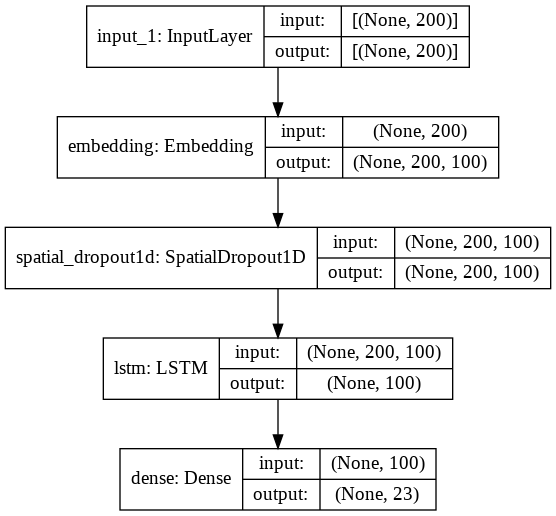

In [37]:
import tensorflow as tf
tf.keras.utils.plot_model(model_LSTM1, to_file='/content/drive/MyDrive/model_LSTM1.png', show_shapes=True, show_layer_names=True)

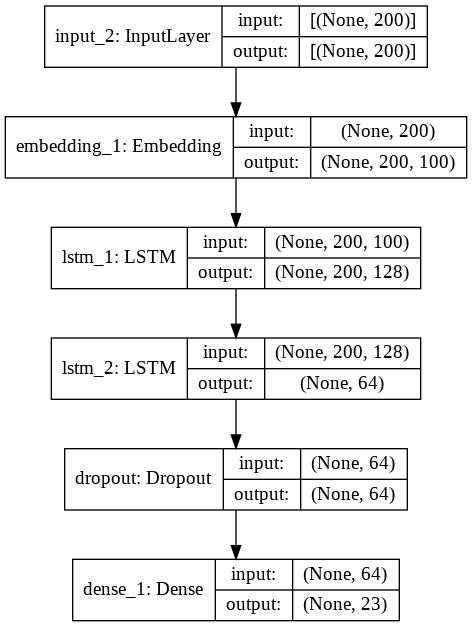

In [38]:
tf.keras.utils.plot_model(model_LSTM2, to_file='/content/drive/MyDrive/model_LSTM2.png', show_shapes=True, show_layer_names=True)

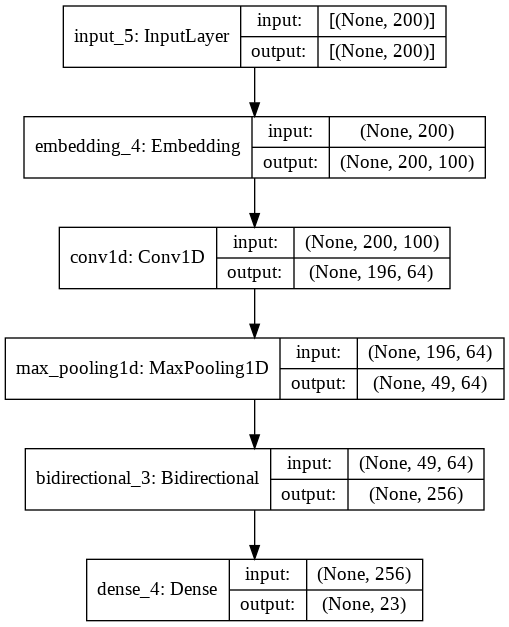

In [39]:
tf.keras.utils.plot_model(model_CLSTM1, to_file='/content/drive/MyDrive/model_CLSTM1.png', show_shapes=True, show_layer_names=True)

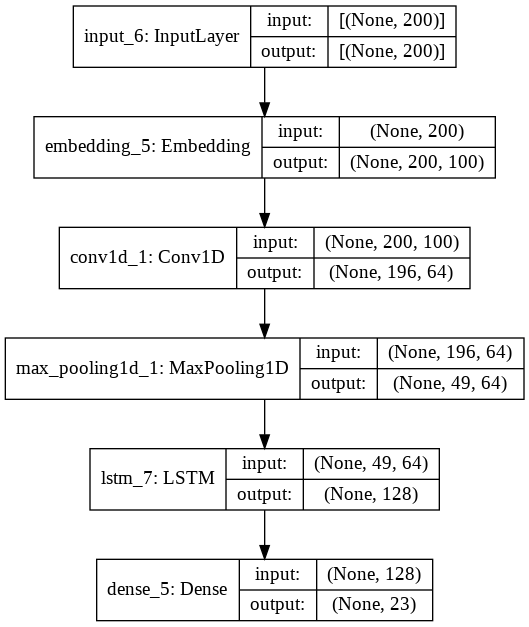

In [40]:
tf.keras.utils.plot_model(model_CLSTM2, to_file='/content/drive/MyDrive/model_CLSTM2.png', show_shapes=True, show_layer_names=True)

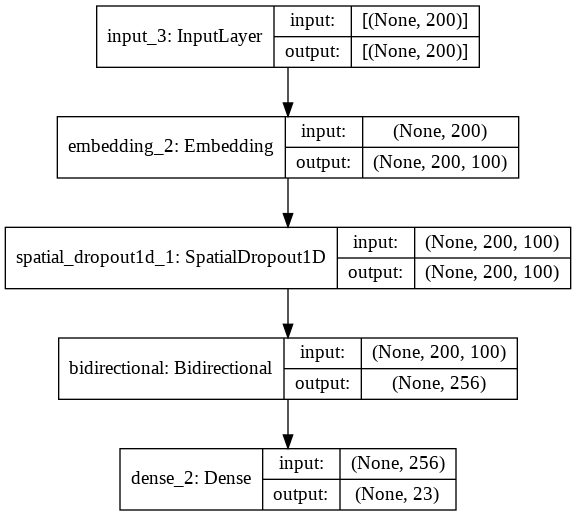

In [41]:
tf.keras.utils.plot_model(model_BLSTM1, to_file='/content/drive/MyDrive/model_BLSTM1.png', show_shapes=True, show_layer_names=True)

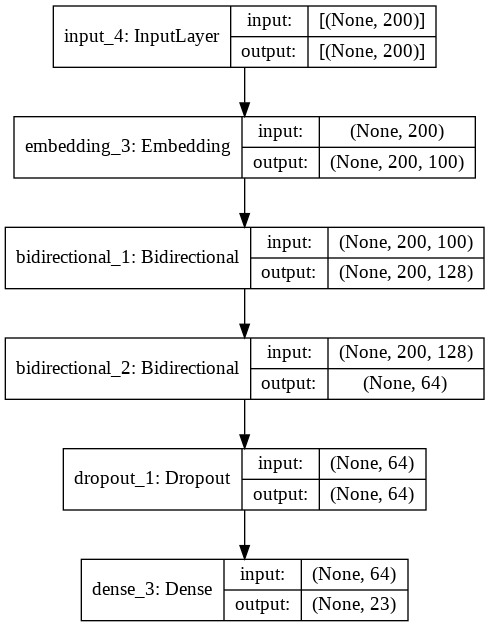

In [42]:
tf.keras.utils.plot_model(model_BLSTM2, to_file='/content/drive/MyDrive/model_BLSTM2.png', show_shapes=True, show_layer_names=True)

## **Training Models**

In [43]:
early = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=10)

In [82]:
model_LSTM1_fit = model_LSTM1.fit(X_train, y_train, batch_size=32, epochs=100 , verbose=1, validation_split=0.2,callbacks=[early]) 

Epoch 1/100
279/279 [==============================] - 107s 367ms/step - loss: 0.3279 - acc: 0.0558 - val_loss: 0.2345 - val_acc: 0.0601
Epoch 2/100
279/279 [==============================] - 102s 364ms/step - loss: 0.2320 - acc: 0.0585 - val_loss: 0.2346 - val_acc: 0.0601
Epoch 3/100
279/279 [==============================] - 100s 357ms/step - loss: 0.2334 - acc: 0.0599 - val_loss: 0.2344 - val_acc: 0.0597
Epoch 4/100
279/279 [==============================] - 101s 360ms/step - loss: 0.2332 - acc: 0.0645 - val_loss: 0.2343 - val_acc: 0.0597
Epoch 5/100
279/279 [==============================] - 99s 355ms/step - loss: 0.2321 - acc: 0.0725 - val_loss: 0.2239 - val_acc: 0.1952
Epoch 6/100
279/279 [==============================] - 100s 358ms/step - loss: 0.2222 - acc: 0.2225 - val_loss: 0.2160 - val_acc: 0.3073
Epoch 7/100
279/279 [==============================] - 99s 356ms/step - loss: 0.2124 - acc: 0.2924 - val_loss: 0.2111 - val_acc: 0.2876
Epoch 8/100
279/279 [======================

In [31]:
model_LSTM1.save("/content/drive/MyDrive/Saved_models_LSTM/saved_model_LSTM1.h5")

In [44]:
model_LSTM2_fit = model_LSTM2.fit(X_train, y_train, batch_size=64, epochs=70 , verbose=1, validation_split=0.2)

Epoch 1/70
140/140 [==============================] - 97s 557ms/step - loss: 0.3723 - acc: 0.0725 - val_loss: 0.2340 - val_acc: 0.0601
Epoch 2/70
140/140 [==============================] - 77s 552ms/step - loss: 0.2378 - acc: 0.0946 - val_loss: 0.2342 - val_acc: 0.0601
Epoch 3/70
140/140 [==============================] - 77s 554ms/step - loss: 0.2411 - acc: 0.0779 - val_loss: 0.2342 - val_acc: 0.0601
Epoch 4/70
140/140 [==============================] - 77s 550ms/step - loss: 0.2348 - acc: 0.0681 - val_loss: 0.2340 - val_acc: 0.0601
Epoch 5/70
140/140 [==============================] - 78s 556ms/step - loss: 0.2351 - acc: 0.0731 - val_loss: 0.2340 - val_acc: 0.0601
Epoch 6/70
140/140 [==============================] - 78s 558ms/step - loss: 0.2356 - acc: 0.0652 - val_loss: 0.2343 - val_acc: 0.0628
Epoch 7/70
140/140 [==============================] - 78s 557ms/step - loss: 0.2368 - acc: 0.0642 - val_loss: 0.2339 - val_acc: 0.0601
Epoch 8/70
140/140 [==============================] - 7

In [45]:
model_LSTM2.save("/content/drive/MyDrive/Saved_models_LSTM/saved_model_LSTM2.h5")

In [80]:
model_CLSTM1_fit = model_CLSTM1.fit(X_train, y_train, batch_size=100, epochs=100 , verbose=1, validation_split=0.2,callbacks=[early]) 

Epoch 1/100
90/90 [==============================] - 37s 359ms/step - loss: 0.3100 - acc: 0.0616 - val_loss: 0.2272 - val_acc: 0.2239
Epoch 2/100
90/90 [==============================] - 32s 352ms/step - loss: 0.2183 - acc: 0.2386 - val_loss: 0.2074 - val_acc: 0.3212
Epoch 3/100
90/90 [==============================] - 31s 341ms/step - loss: 0.2019 - acc: 0.3073 - val_loss: 0.1967 - val_acc: 0.3553
Epoch 4/100
90/90 [==============================] - 31s 344ms/step - loss: 0.1872 - acc: 0.3610 - val_loss: 0.1861 - val_acc: 0.3692
Epoch 5/100
90/90 [==============================] - 32s 352ms/step - loss: 0.1778 - acc: 0.4107 - val_loss: 0.1794 - val_acc: 0.4015
Epoch 6/100
90/90 [==============================] - 32s 352ms/step - loss: 0.1668 - acc: 0.4502 - val_loss: 0.1738 - val_acc: 0.4509
Epoch 7/100
90/90 [==============================] - 31s 343ms/step - loss: 0.1593 - acc: 0.4961 - val_loss: 0.1665 - val_acc: 0.4652
Epoch 8/100
90/90 [==============================] - 31s 346ms

In [226]:
model_CLSTM1.save("/content/drive/MyDrive/Saved_models_LSTM/saved_model_CLSTM1.h5")

In [81]:
model_CLSTM2_fit = model_CLSTM2.fit(X_train, y_train, batch_size=100, epochs=100 , verbose=1, validation_split=0.2,callbacks=[early])

Epoch 1/100
90/90 [==============================] - 30s 287ms/step - loss: 0.3817 - acc: 0.0517 - val_loss: 0.2345 - val_acc: 0.0633
Epoch 2/100
90/90 [==============================] - 25s 283ms/step - loss: 0.2313 - acc: 0.0584 - val_loss: 0.2342 - val_acc: 0.0606
Epoch 3/100
90/90 [==============================] - 25s 277ms/step - loss: 0.2312 - acc: 0.0620 - val_loss: 0.2336 - val_acc: 0.0610
Epoch 4/100
90/90 [==============================] - 26s 283ms/step - loss: 0.2307 - acc: 0.0617 - val_loss: 0.2336 - val_acc: 0.0610
Epoch 5/100
90/90 [==============================] - 25s 283ms/step - loss: 0.2315 - acc: 0.0682 - val_loss: 0.2254 - val_acc: 0.2790
Epoch 6/100
90/90 [==============================] - 25s 279ms/step - loss: 0.2198 - acc: 0.2493 - val_loss: 0.2149 - val_acc: 0.3122
Epoch 7/100
90/90 [==============================] - 25s 276ms/step - loss: 0.2093 - acc: 0.3079 - val_loss: 0.2100 - val_acc: 0.3078
Epoch 8/100
90/90 [==============================] - 25s 279ms

In [227]:
model_CLSTM2.save("/content/drive/MyDrive/Saved_models_LSTM/saved_model_CLSTM2.h5")

In [66]:
model_BLSTM1_fit = model_BLSTM1.fit(X_train, y_train, batch_size=100, epochs=100 , verbose=1, validation_split=0.2,callbacks=[early]) 

Epoch 1/100
90/90 [==============================] - 152s 2s/step - loss: 0.3663 - acc: 0.0774 - val_loss: 0.2321 - val_acc: 0.0601
Epoch 2/100
90/90 [==============================] - 139s 2s/step - loss: 0.2273 - acc: 0.1086 - val_loss: 0.2104 - val_acc: 0.2485
Epoch 3/100
90/90 [==============================] - 141s 2s/step - loss: 0.2079 - acc: 0.2722 - val_loss: 0.1967 - val_acc: 0.3396
Epoch 4/100
90/90 [==============================] - 141s 2s/step - loss: 0.1917 - acc: 0.3401 - val_loss: 0.1858 - val_acc: 0.3988
Epoch 5/100
90/90 [==============================] - 141s 2s/step - loss: 0.1857 - acc: 0.3748 - val_loss: 0.1796 - val_acc: 0.4320
Epoch 6/100
90/90 [==============================] - 141s 2s/step - loss: 0.1780 - acc: 0.4188 - val_loss: 0.1739 - val_acc: 0.4531
Epoch 7/100
90/90 [==============================] - 141s 2s/step - loss: 0.1716 - acc: 0.4431 - val_loss: 0.1669 - val_acc: 0.4751
Epoch 8/100
90/90 [==============================] - 141s 2s/step - loss: 0.

In [218]:
model_BLSTM1.save("/content/drive/MyDrive/Saved_models_LSTM/saved_model_BLSTM1.h5")

In [68]:
model_BLSTM2_fit = model_BLSTM2.fit(X_train, y_train, batch_size=100, epochs=100 , verbose=1, validation_split=0.2,callbacks=[early]) 

Epoch 1/100
90/90 [==============================] - 64s 636ms/step - loss: 0.4279 - acc: 0.0395 - val_loss: 0.2338 - val_acc: 0.0601
Epoch 2/100
90/90 [==============================] - 56s 618ms/step - loss: 0.2391 - acc: 0.0855 - val_loss: 0.2332 - val_acc: 0.0601
Epoch 3/100
90/90 [==============================] - 56s 620ms/step - loss: 0.2356 - acc: 0.0953 - val_loss: 0.2244 - val_acc: 0.2028
Epoch 4/100
90/90 [==============================] - 55s 614ms/step - loss: 0.2250 - acc: 0.2311 - val_loss: 0.2122 - val_acc: 0.3100
Epoch 5/100
90/90 [==============================] - 55s 612ms/step - loss: 0.2123 - acc: 0.2952 - val_loss: 0.2050 - val_acc: 0.3096
Epoch 6/100
90/90 [==============================] - 55s 615ms/step - loss: 0.2039 - acc: 0.3162 - val_loss: 0.1973 - val_acc: 0.3297
Epoch 7/100
90/90 [==============================] - 56s 625ms/step - loss: 0.1958 - acc: 0.3432 - val_loss: 0.1902 - val_acc: 0.3921
Epoch 8/100
90/90 [==============================] - 57s 628ms

In [219]:
model_BLSTM2.save("/content/drive/MyDrive/Saved_models_LSTM/saved_model_BLSTM2.h5")

### **Accuracy and Loss plots diagrams for training and validation**

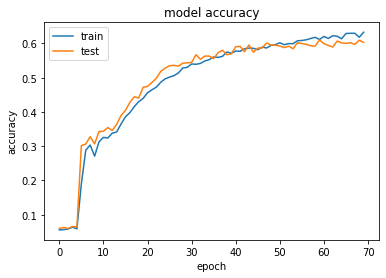

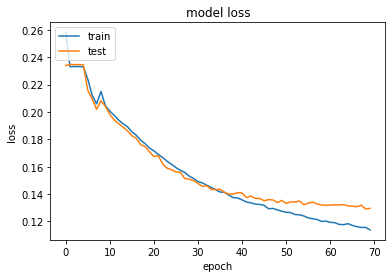

In [48]:
plt.plot(model_LSTM1_fit.history['acc'])
plt.plot(model_LSTM1_fit.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(model_LSTM1_fit.history['loss'])
plt.plot(model_LSTM1_fit.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

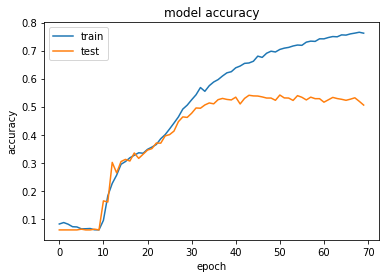

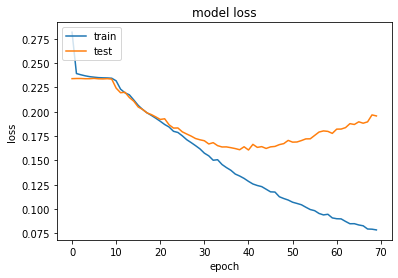

In [57]:
plt.plot(model_LSTM2_fit.history['acc'])
plt.plot(model_LSTM2_fit.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(model_LSTM2_fit.history['loss'])
plt.plot(model_LSTM2_fit.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

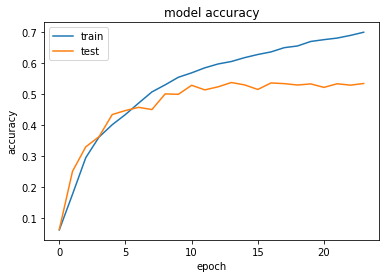

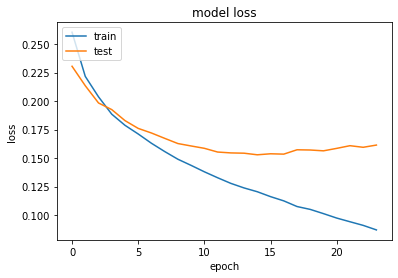

In [50]:
plt.plot(model_CLSTM1_fit.history['acc'])
plt.plot(model_CLSTM1_fit.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(model_CLSTM1_fit.history['loss'])
plt.plot(model_CLSTM1_fit.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

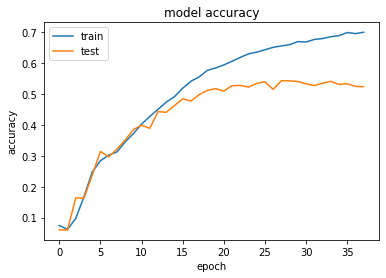

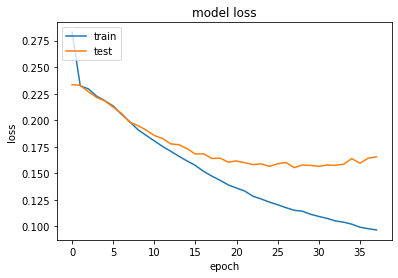

In [51]:
plt.plot(model_CLSTM2_fit.history['acc'])
plt.plot(model_CLSTM2_fit.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(model_CLSTM2_fit.history['loss'])
plt.plot(model_CLSTM2_fit.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

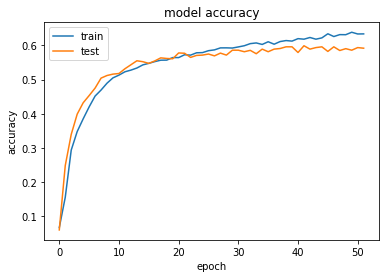

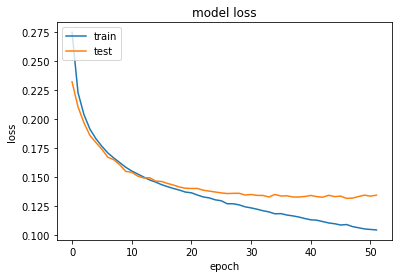

In [70]:
plt.plot(model_BLSTM1_fit.history['acc'])
plt.plot(model_BLSTM1_fit.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(model_BLSTM1_fit.history['loss'])
plt.plot(model_BLSTM1_fit.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

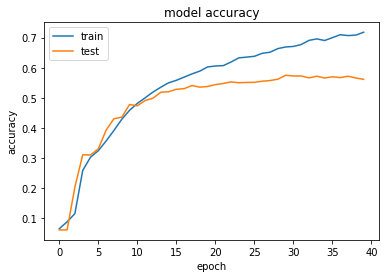

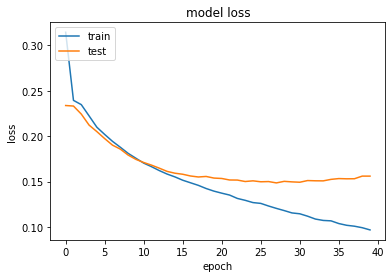

In [71]:
plt.plot(model_BLSTM2_fit.history['acc'])
plt.plot(model_BLSTM2_fit.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(model_BLSTM2_fit.history['loss'])
plt.plot(model_BLSTM2_fit.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

###**Computing the highest of the evaluation matrics**

In [86]:
from plotly.offline import iplot
import plotly.graph_objs as go
trace = go.Table(
    header=dict(values=['Model', 'Loss', 'Accuracy'],
                line = dict(color='#7D7F80'),
                fill = dict(color='#a1c3d1'),
                align = ['left'] * 5),
    cells=dict(values=[['LSTM1 ', 'LSTM2', 'BLSTM1','BLSTM2 ', 'CLSTM1', 'CLSTM2'],
                       [
                        #Loss Evaluation
                        round(np.max(model_LSTM1_fit.history['loss']), 3), round(np.max(model_LSTM2_fit.history['loss']), 3), 
                        round(np.max(model_BLSTM1_fit.history['loss']), 3),round(np.max(model_BLSTM2_fit.history['loss']), 3), round(np.max(model_CLSTM1_fit.history['loss']), 3), 
                        round(np.max(model_CLSTM2_fit.history['loss']), 3)],
                        
                        #Accuracy Evaluation
                        [round(np.max(model_LSTM1_fit.history['acc']), 3), round(np.max(model_LSTM2_fit.history['acc']), 3), 
                        round(np.max(model_BLSTM1_fit.history['acc']), 3),round(np.max(model_BLSTM2_fit.history['acc']), 3), round(np.max(model_CLSTM1_fit.history['acc']), 3), 
                        round(np.max(model_CLSTM2_fit.history['acc']), 3)],
               ],
               line = dict(color='#7D7F80'),
               fill = dict(color='#EDFAFF'),
               align = ['left'] * 5))
layout = dict(width=400, height=200)
data = [trace]
fig = dict(data=data, layout=layout)
iplot(data, filename = 'Glove_trained_embedding_with the max of the evaluation matrics (per model) _table')

##**Models evaluation**

In [83]:
model_LSTM1_test_score = model_LSTM1.evaluate(X_test, y_test, verbose = 1)
print('Test loss:', model_LSTM1_test_score[0])
print('Test accuracy:', model_LSTM1_test_score[1])

88/88 [==============================] - 5s 54ms/step - loss: 0.1355 - acc: 0.5757
Test loss: 0.13545924425125122
Test accuracy: 0.5757358074188232


In [56]:
model_LSTM2_test_score = model_LSTM2.evaluate(X_test, y_test, verbose = 1)
print('Test loss:', model_LSTM2_test_score[0])
print('Test accuracy:', model_LSTM2_test_score[1])

88/88 [==============================] - 8s 86ms/step - loss: 0.2003 - acc: 0.5050
Test loss: 0.20030559599399567
Test accuracy: 0.5050251483917236


In [84]:
model_CLSTM1_test_score = model_CLSTM1.evaluate(X_test, y_test,verbose = 1)
print('Test loss:', model_CLSTM1_test_score[0])
print('Test accuracy:', model_CLSTM1_test_score[1])

88/88 [==============================] - 3s 32ms/step - loss: 0.1816 - acc: 0.5104
Test loss: 0.18162035942077637
Test accuracy: 0.5104091763496399


In [85]:
model_CLSTM2_test_score = model_CLSTM2.evaluate(X_test, y_test,verbose = 1)
print('Test loss:', model_CLSTM2_test_score[0])
print('Test accuracy:', model_CLSTM2_test_score[1])

88/88 [==============================] - 2s 25ms/step - loss: 0.1648 - acc: 0.5388
Test loss: 0.16482263803482056
Test accuracy: 0.5387652516365051


In [72]:
model_BLSTM1_test_score = model_BLSTM1.evaluate(X_test, y_test,verbose = 1)
print('Test loss:', model_BLSTM1_test_score[0])
print('Test accuracy:', model_BLSTM1_test_score[1])

88/88 [==============================] - 10s 118ms/step - loss: 0.1378 - acc: 0.5772
Test loss: 0.13776546716690063
Test accuracy: 0.5771715641021729


In [73]:
model_BLSTM2_test_score = model_BLSTM2.evaluate(X_test, y_test,verbose = 1)
print('Test loss:', model_BLSTM2_test_score[0])
print('Test accuracy:', model_BLSTM2_test_score[1])

88/88 [==============================] - 7s 81ms/step - loss: 0.1565 - acc: 0.5456
Test loss: 0.1565057337284088
Test accuracy: 0.5455850958824158


**Concat all training, validation and testing accuracy scores**

In [87]:
# concat all training, validation and testing accuracy scores
model_LSTM1_Accuracy = ['LSTM1 with Glove', 
                np.max(model_LSTM1_fit.history['acc']), 
                np.max(model_LSTM1_fit.history['val_acc']), 
                model_LSTM1_test_score[1]]

model_LSTM2_Accuracy = ['LSTM2 with Glove', 
                np.max(model_LSTM2_fit.history['acc']), 
                np.max(model_LSTM2_fit.history['val_acc']), 
                model_LSTM2_test_score[1]]

model_CLSTM1_Accuracy = ['CLSTM1 with Glove', 
                  np.max(model_CLSTM1_fit.history['acc']), 
                  np.max(model_CLSTM1_fit.history['val_acc']), 
                  model_CLSTM1_test_score[1]]

model_CLSTM2_Accuracy = ['CLSTM2 with Glove', 
                    np.max(model_CLSTM2_fit.history['acc']), 
                    np.max(model_CLSTM2_fit.history['val_acc']), 
                    model_CLSTM2_test_score[1]]

model_BLSTM1_Accuracy = ['BLSTM1 with Glove', 
                    np.max(model_BLSTM1_fit.history['acc']), 
                    np.max(model_BLSTM1_fit.history['val_acc']), 
                    model_BLSTM1_test_score[1]]

model_BLSTM2_Accuracy = ['BLSTM2 with Glove', 
                    np.max(model_BLSTM2_fit.history['acc']), 
                    np.max(model_BLSTM2_fit.history['val_acc']), 
                    model_BLSTM2_test_score[1]]
# create dataframe
experimentalResult = pd.DataFrame()
# append all other scores
experimentalResult = experimentalResult.append([model_LSTM1_Accuracy, model_LSTM2_Accuracy, model_CLSTM1_Accuracy, model_CLSTM2_Accuracy, 
                                                model_BLSTM1_Accuracy, model_BLSTM2_Accuracy])


# beautify the new dataframe
experimentalResult.columns = ['Model', 'Training Accuracy', 'Validation Accuracy', 'Testing Accuracy']
experimentalResult.set_index(['Model'], inplace=True)
experimentalResult
print(experimentalResult)

                   Training Accuracy  Validation Accuracy  Testing Accuracy
Model                                                                      
LSTM1 with Glove            0.634844             0.611036          0.575736
LSTM2 with Glove            0.765537             0.541498          0.505025
CLSTM1 with Glove           0.733116             0.536115          0.510409
CLSTM2 with Glove           0.685551             0.546433          0.538765
BLSTM1 with Glove           0.638434             0.598923          0.577172
BLSTM2 with Glove           0.717972             0.574697          0.545585


# **Prediction**

In [220]:
pred1 = model_LSTM1.predict(X_test)
pred2 = model_LSTM2.predict(X_test)
pred3 = model_CLSTM1.predict(X_test)
pred4 = model_CLSTM2.predict(X_test)
pred5 = model_BLSTM1.predict(X_test)
pred6 = model_BLSTM2.predict(X_test)

In [221]:
pred1 =np.round(pred1)
pred2 =np.round(pred2)
pred3 =np.round(pred3)
pred4 =np.round(pred4)
pred5 =np.round(pred5)
pred6 =np.round(pred6)

In [28]:
from sklearn.metrics import accuracy_score, f1_score,classification_report,multilabel_confusion_matrix

In [232]:
print(classification_report(y_test, pred1),"classification_report LSTM1")

              precision    recall  f1-score   support

           0       0.71      0.55      0.62       188
           1       0.67      0.16      0.26        97
           2       0.50      0.15      0.23        20
           3       0.83      0.79      0.81       555
           4       0.69      0.38      0.49       134
           5       0.78      0.71      0.74       241
           6       0.44      0.10      0.16        40
           7       0.73      0.54      0.62       215
           8       0.14      0.02      0.04        49
           9       0.61      0.57      0.59       317
          10       0.80      0.54      0.65        74
          11       0.86      0.67      0.76       218
          12       0.71      0.50      0.59       144
          13       0.83      0.75      0.79       505
          14       0.86      0.32      0.47       116
          15       0.60      0.34      0.43        83
          16       0.77      0.45      0.56       132
          17       0.78    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.



In [233]:
print(classification_report(y_test, pred2),"classification_report LSTM2")

              precision    recall  f1-score   support

           0       0.66      0.48      0.56       188
           1       0.54      0.13      0.21        97
           2       0.67      0.10      0.17        20
           3       0.79      0.75      0.77       555
           4       0.47      0.41      0.44       134
           5       0.65      0.59      0.62       241
           6       0.18      0.10      0.13        40
           7       0.53      0.54      0.53       215
           8       0.17      0.08      0.11        49
           9       0.50      0.51      0.50       317
          10       0.43      0.34      0.38        74
          11       0.76      0.56      0.64       218
          12       0.66      0.35      0.45       144
          13       0.83      0.69      0.76       505
          14       0.59      0.11      0.19       116
          15       0.19      0.05      0.08        83
          16       0.68      0.34      0.45       132
          17       0.59    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.



In [234]:
print(classification_report(y_test, pred3),"classification_report CLSTM1")

              precision    recall  f1-score   support

           0       0.73      0.43      0.54       188
           1       0.53      0.27      0.36        97
           2       0.00      0.00      0.00        20
           3       0.82      0.73      0.77       555
           4       0.52      0.37      0.43       134
           5       0.70      0.64      0.67       241
           6       0.45      0.12      0.20        40
           7       0.60      0.47      0.53       215
           8       0.29      0.10      0.15        49
           9       0.57      0.49      0.52       317
          10       0.55      0.24      0.34        74
          11       0.79      0.60      0.68       218
          12       0.67      0.51      0.58       144
          13       0.82      0.67      0.74       505
          14       0.50      0.22      0.30       116
          15       0.47      0.24      0.32        83
          16       0.56      0.31      0.40       132
          17       0.71    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.



In [235]:
print(classification_report(y_test, pred4),"classification_report CLSTM2")

              precision    recall  f1-score   support

           0       0.66      0.55      0.60       188
           1       0.73      0.16      0.27        97
           2       0.25      0.05      0.08        20
           3       0.81      0.80      0.80       555
           4       0.45      0.46      0.46       134
           5       0.69      0.64      0.66       241
           6       0.60      0.07      0.13        40
           7       0.76      0.46      0.57       215
           8       0.31      0.08      0.13        49
           9       0.60      0.44      0.51       317
          10       0.65      0.27      0.38        74
          11       0.64      0.72      0.68       218
          12       0.63      0.42      0.51       144
          13       0.80      0.74      0.77       505
          14       0.56      0.13      0.21       116
          15       0.47      0.10      0.16        83
          16       0.59      0.43      0.50       132
          17       0.55    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.



In [236]:
print(classification_report(y_test, pred5),"classification_report BLSTM1")

              precision    recall  f1-score   support

           0       0.81      0.51      0.62       188
           1       0.63      0.30      0.41        97
           2       0.57      0.20      0.30        20
           3       0.81      0.85      0.83       555
           4       0.64      0.48      0.55       134
           5       0.72      0.65      0.68       241
           6       0.64      0.23      0.33        40
           7       0.76      0.56      0.65       215
           8       0.33      0.10      0.16        49
           9       0.63      0.49      0.55       317
          10       0.80      0.55      0.66        74
          11       0.77      0.76      0.77       218
          12       0.74      0.49      0.59       144
          13       0.76      0.81      0.78       505
          14       0.76      0.22      0.34       116
          15       0.44      0.41      0.42        83
          16       0.72      0.45      0.56       132
          17       0.76    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.



In [237]:
print(classification_report(y_test, pred6),"classification_report BLSTM2")

              precision    recall  f1-score   support

           0       0.63      0.64      0.63       188
           1       0.46      0.12      0.20        97
           2       0.00      0.00      0.00        20
           3       0.84      0.68      0.75       555
           4       0.61      0.45      0.52       134
           5       0.73      0.61      0.67       241
           6       0.25      0.03      0.05        40
           7       0.61      0.56      0.59       215
           8       0.20      0.02      0.04        49
           9       0.71      0.44      0.55       317
          10       0.71      0.32      0.44        74
          11       0.72      0.68      0.70       218
          12       0.75      0.47      0.58       144
          13       0.80      0.75      0.77       505
          14       0.71      0.17      0.28       116
          15       0.47      0.28      0.35        83
          16       0.71      0.39      0.51       132
          17       0.73    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.



Experimental Results for each model individually.\
P: Precision, R: Recall, F1: F1-Score, Acc: Accuracy

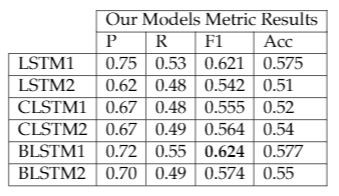

## **Confusion Matrix**

In [42]:
LBNAM=["C01", "C02", "C03", "C04", "C05", "C06", "C07", "C08", "C09", "C10", "C11", "C12", "C13", "C14", "C15", "C16", "C17", "C18", "C19", "C20", "C21", "C22", "C23"]

In [238]:
MCP1=multilabel_confusion_matrix(y_test,pred1)
MCP2=multilabel_confusion_matrix(y_test,pred2)
MCP3=multilabel_confusion_matrix(y_test,pred3)
MCP4=multilabel_confusion_matrix(y_test,pred4)
MCP5=multilabel_confusion_matrix(y_test,pred5)
MCP6=multilabel_confusion_matrix(y_test,pred6)

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=8):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("CM for the label - " + class_label)

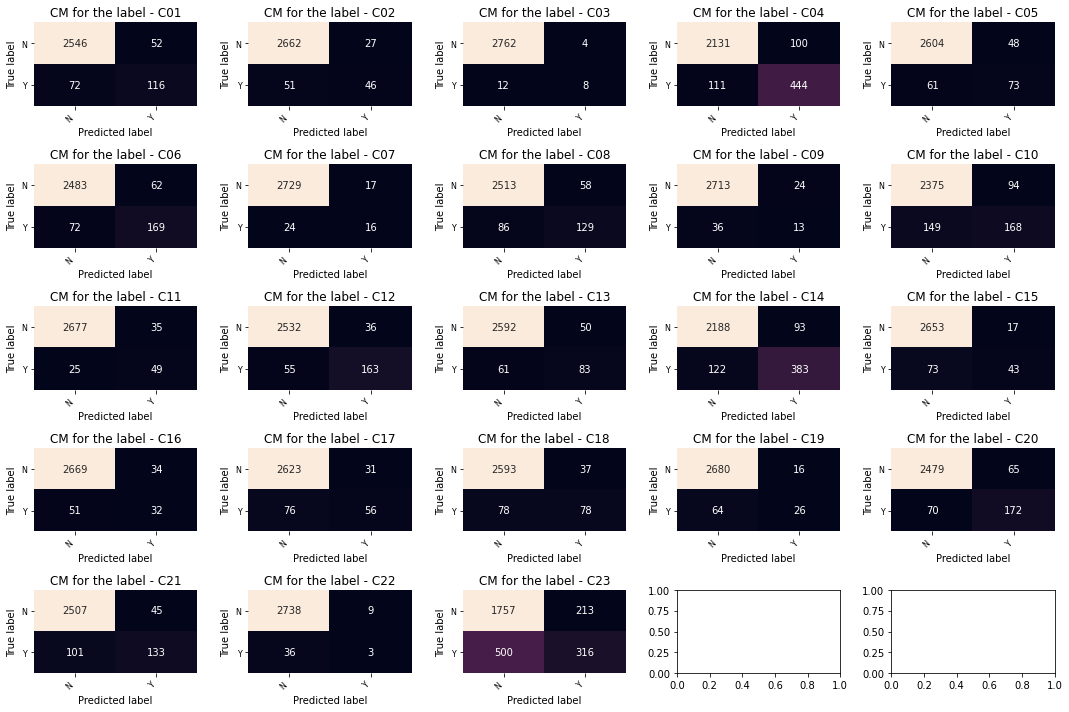

In [59]:
fig, ax = plt.subplots(5, 5, figsize=(15, 10))
    
for axes, cfs_matrix, label in zip(ax.flatten(), MCP1, LBNAM):
  print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    
fig.tight_layout()
plt.show()

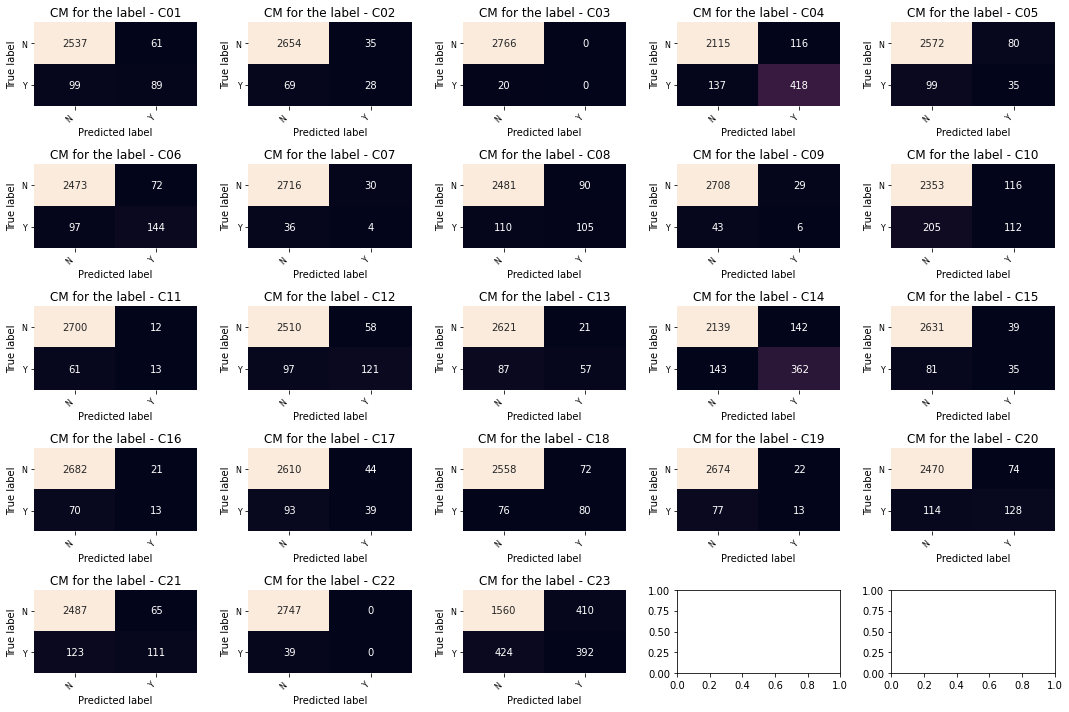

In [101]:
fig, ax = plt.subplots(5, 5, figsize=(15, 10))
    
for axes, cfs_matrix, label in zip(ax.flatten(), MCP2, LBNAM):
  print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    
fig.tight_layout()
plt.show()

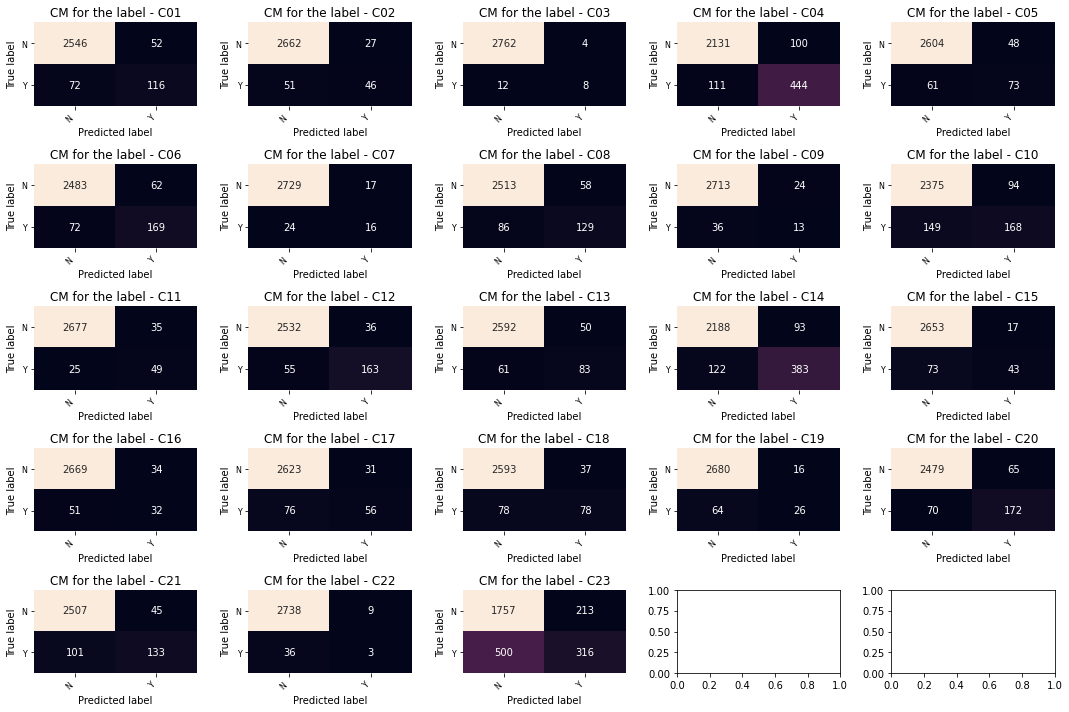

In [102]:
fig, ax = plt.subplots(5, 5, figsize=(15, 10))
    
for axes, cfs_matrix, label in zip(ax.flatten(), MCP3, LBNAM):
  print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    
fig.tight_layout()
plt.show()

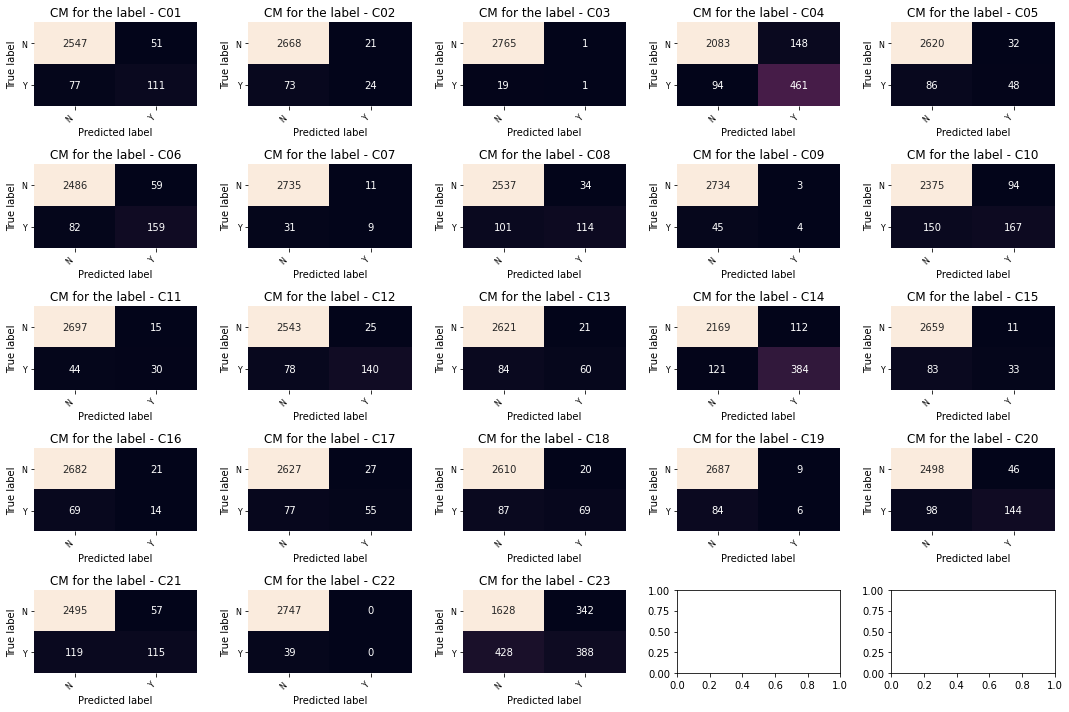

In [103]:
fig, ax = plt.subplots(5, 5, figsize=(15, 10))
    
for axes, cfs_matrix, label in zip(ax.flatten(), MCP4, LBNAM):
  print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    
fig.tight_layout()
plt.show()

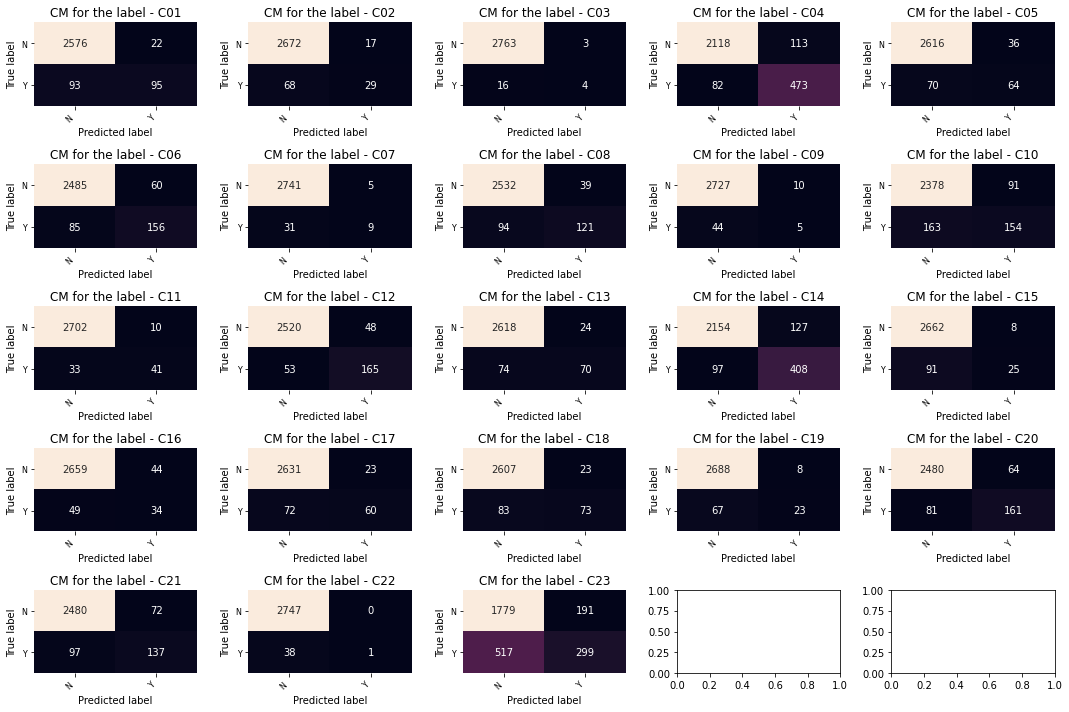

In [239]:
fig, ax = plt.subplots(5, 5, figsize=(15, 10))
    
for axes, cfs_matrix, label in zip(ax.flatten(), MCP5, LBNAM):
  print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    
fig.tight_layout()
plt.show()

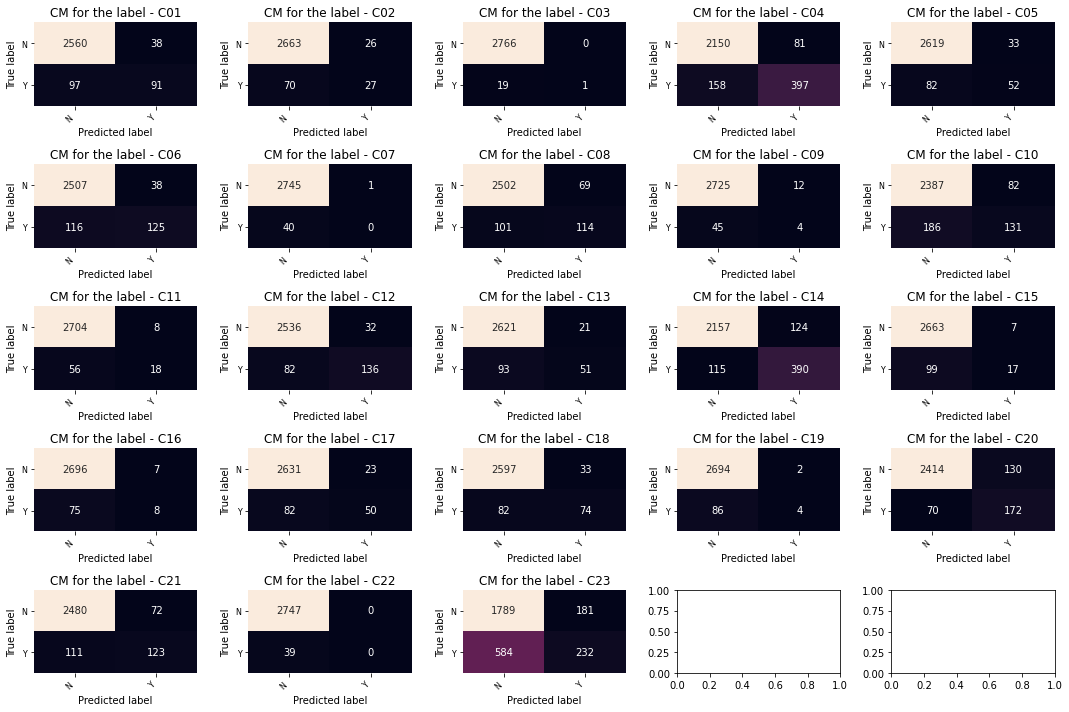

In [105]:
fig, ax = plt.subplots(5, 5, figsize=(15, 10))
    
for axes, cfs_matrix, label in zip(ax.flatten(), MCP6, LBNAM):
  print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    
fig.tight_layout()
plt.show()

# **Fusion**

In [199]:
def voting_classifiersV1(pred,pred1,pred2,pred3,pred4,pred5):
  df=pd.DataFrame(pred)
  df1=pd.DataFrame(pred1)
  df2=pd.DataFrame(pred2)
  df3=pd.DataFrame(pred3)
  df4=pd.DataFrame(pred4)
  df5=pd.DataFrame(pred5)
  df6=sum([df, df1, df2, df3, df4, df5])
  for i in range(df6.shape[1]):
    for j in range(df6.shape[0]):
      if df6[i][j]==0.0 or df6[i][j]==1.0 or df6[i][j]==2.0:
        df6[i][j]=0.0
      else:
        df6[i][j]=1.0
  FPC=df6.to_numpy()
  return FPC

In [200]:
FAP=voting_classifiersV1(pred1,pred2,pred3,pred4,pred5,pred6)

In [202]:
print(classification_report(y_test, FAP),"Fusion of all prediction")

              precision    recall  f1-score   support

           0       0.77      0.57      0.65       188
           1       0.69      0.23      0.34        97
           2       1.00      0.05      0.10        20
           3       0.83      0.83      0.83       555
           4       0.65      0.53      0.58       134
           5       0.77      0.70      0.73       241
           6       0.83      0.12      0.22        40
           7       0.75      0.58      0.65       215
           8       0.25      0.04      0.07        49
           9       0.66      0.50      0.57       317
          10       0.76      0.42      0.54        74
          11       0.84      0.72      0.77       218
          12       0.75      0.52      0.61       144
          13       0.80      0.79      0.79       505
          14       0.88      0.19      0.31       116
          15       0.61      0.23      0.33        83
          16       0.78      0.43      0.56       132
          17       0.74    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.



Experimental Results for each model individually and the fusing of all predictions.

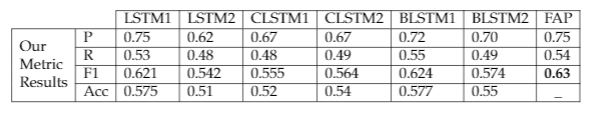

In [203]:
def voting_classifiersV0(pred,pred1,pred2):
  df=pd.DataFrame(pred)
  df1=pd.DataFrame(pred1)
  df2=pd.DataFrame(pred2)
  df4=sum([df, df1, df2])
  for i in range(df4.shape[1]):
    for j in range(df4.shape[0]):
      if df4[i][j]==3.0 or df4[i][j]==2.0:
        df4[i][j]=1.0
      else:
        df4[i][j]=0.0
  FPC=df4.to_numpy()
  return FPC

In [204]:
FSP=voting_classifiersV0(pred1,pred5,pred6)

In [198]:
print(classification_report(y_test, FSP),"Fusion of selected prediction")

              precision    recall  f1-score   support

           0       0.79      0.61      0.69       188
           1       0.57      0.21      0.30        97
           2       0.67      0.10      0.17        20
           3       0.84      0.82      0.83       555
           4       0.70      0.51      0.59       134
           5       0.78      0.65      0.71       241
           6       0.50      0.05      0.09        40
           7       0.76      0.59      0.66       215
           8       0.33      0.06      0.10        49
           9       0.71      0.45      0.55       317
          10       0.84      0.50      0.63        74
          11       0.82      0.73      0.77       218
          12       0.76      0.53      0.63       144
          13       0.79      0.79      0.79       505
          14       0.82      0.23      0.36       116
          15       0.57      0.30      0.39        83
          16       0.84      0.44      0.58       132
          17       0.78    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.



Experimental Results for Fusion of the selected classifiers pridiction and the 

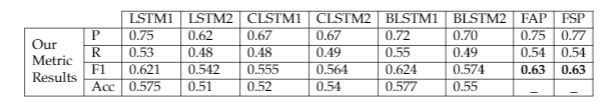

In [206]:
MCPFSP=multilabel_confusion_matrix(y_test,FSP)

In [207]:
MCPFAP=multilabel_confusion_matrix(y_test,FAP)

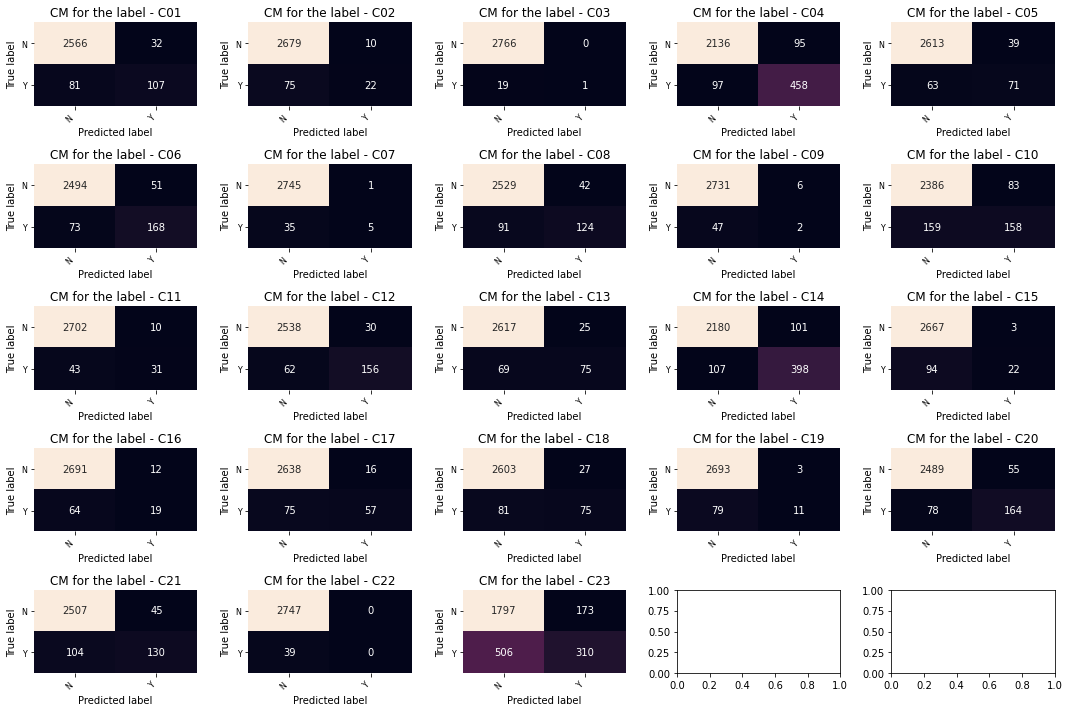

In [213]:
fig, ax = plt.subplots(5, 5, figsize=(15, 10))
    
for axes, cfs_matrix, label in zip(ax.flatten(), MCPFAP, LBNAM):
  print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    
fig.tight_layout()
plt.show()

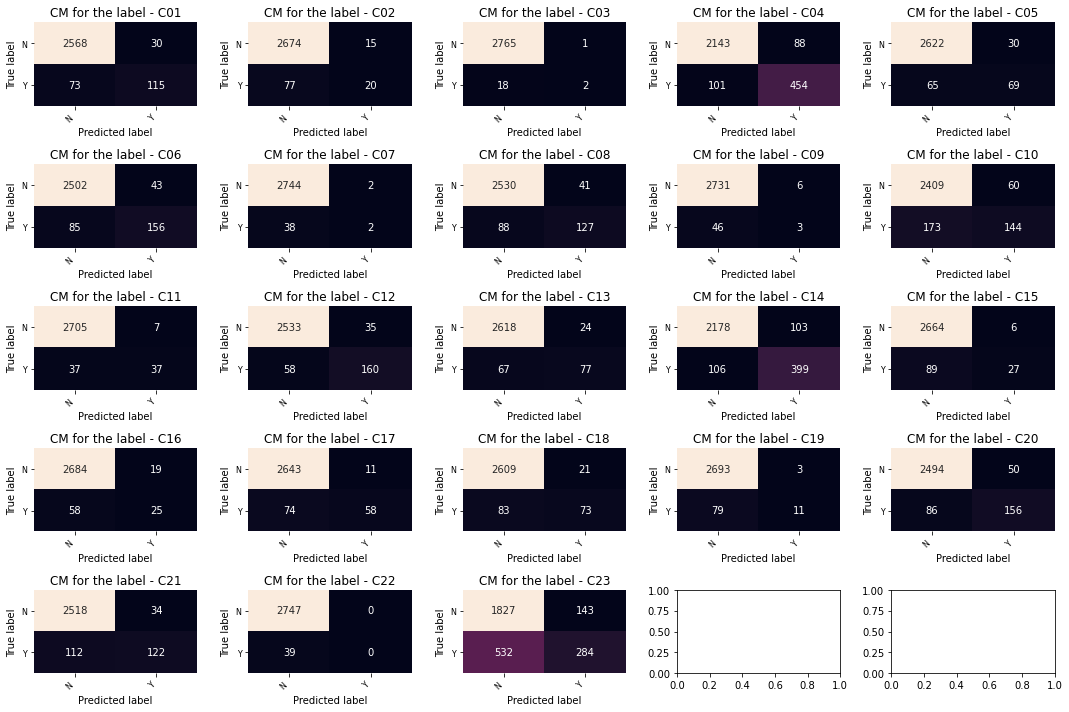

In [212]:
fig, ax = plt.subplots(5, 5, figsize=(15, 10))
    
for axes, cfs_matrix, label in zip(ax.flatten(), MCPFSP, LBNAM):
  print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    
fig.tight_layout()
plt.show()